In [1]:
import torch, detectron2

from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import  get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.detection_utils import read_image
import detectron2.data.transforms as T
from detectron2.data.datasets import register_coco_instances, load_coco_json

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import data_loaders

In [2]:
#import os

# Directorio donde se encuentran las imágenes originales
#directorio = 'frames/'

# Itera sobre todas las imágenes en el directorio
#for i, nombre_archivo in enumerate(os.listdir(directorio)):
    # Construye el nuevo nombre de archivo con el formato deseado
#    nuevo_nombre = f"{i+1:05d}.jpg"
    # Renombra el archivo
#    os.rename(os.path.join(directorio, nombre_archivo), os.path.join(directorio, nuevo_nombre))

#print("Renombrado completado.")

import os

# Directorio donde se encuentran las imágenes originales
directorio = '../frames'

# Itera sobre todas las imágenes en el directorio
for i, nombre_archivo in enumerate(os.listdir(directorio)):
    # Construye el nuevo nombre de archivo con el formato deseado
    nuevo_nombre = f"{i:05d}.jpg"
    # Renombra el archivo
    os.rename(os.path.join(directorio, nombre_archivo), os.path.join(directorio, nuevo_nombre))

print("Renombrado completado.")

In [3]:
class Detector:
    
    def __init__(self, model_type = "OD", outpath:str="./random"):
        self.cfg = get_cfg()
        
        #Load model config and pretrained model
        if model_type == "OD":
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")      
            
            
        elif model_type == "IS":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")      
            
        elif model_type == "KP":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")      
            
                
        self.cfg.OUTPUT_DIR =   os.path.join(outpath, "faster")   
        self.cfg.defrost()

        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        self.cfg.MODEL.DEVICE = "cuda"
        self.cfg.SOLVER.IMS_PER_BATCH = 4
        self.cfg.SOLVER.CHECKPOINT_PERIOD = 250
        self.cfg.SOLVER.MAX_ITER = 1500
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

        #self.cfg.SOLVER.IMS_PER_BATCH = 4
        #self.cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

        self.__loader_mapping = loader_mapping = {
                                                'first': data_loaders.load_sequential_hold_out,
                                                'random': data_loaders.load_random_data,
                                                '13': data_loaders.load_13,
                                                '12': data_loaders.load_12,
                                                '23': data_loaders.load_23
                                            }
        
        self._datasets = {"train": None, "val": None}
        self._metadata = { "train": None, "val": None }


    def prepare_dataset(self, kind:str = "first", kfolds:bool=False, select_folds:str="12"):
        self.loader = self.__loader_mapping.get(kind if not kfolds else select_folds, None)


        if self.loader is None:
            raise ValueError("Invalid split or folds value")

        for data_type in ['train', 'val']:
            static = set(["1","2","3"])
            query  = set(list(select_folds))
            test_name = list(static  - query)[-1]
            
            if data_type == "val":
                dataset_name = os.path.join("datafolds", f"{data_type}_{kind if not kfolds else test_name}")
                self.cfg.DATASETS.TEST = f"{data_type}_dataset"
           
            else:
                dataset_name = os.path.join("datafolds", f"{data_type}_{kind if not kfolds else select_folds}")
                self.cfg.DATASETS.TRAIN = f"{data_type}_dataset"
            
            #register_coco_instances(f"{data_type}_dataset", {}, dataset_name+".json", "./frames")
            print(data_type)
            print(dataset_name+".json")
            self._metadata[data_type] = MetadataCatalog.get(f"{data_type}_dataset").set(thing_classes=["car", "bike"])            
            self._datasets[data_type] = DatasetCatalog.register(f"{data_type}_dataset", lambda d=data_type: self.loader(data_type) )

        os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)

    def fit_(self):

        trainer = DefaultTrainer(self.cfg)
        #DefaultTrainer.build_train_loader = lambda: dataloader

        trainer.resume_or_load(resume=False)

        trainer.train()



        

     

In [4]:
detector = Detector(model_type="OD", outpath="./first")
detector.prepare_dataset(kind = "first", kfolds=False, select_folds="12")

train
datafolds/train_first.json
val
datafolds/val_first.json


In [5]:
detector.fit_()

[03/05 17:24:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

FileNotFoundError: [Errno 2] No such file or directory: 'val_first.json'

In [9]:
DatasetCatalog.get("val_dataset")

[{'id': 1415,
  'license': 1,
  'file_name': 'frames/01415.jpg',
  'height': 1080,
  'width': 1920,
  'date_captured': None,
  'image_id': 1415,
  'annotations': [{'id': 3257,
    'image_id': 1415,
    'category_id': 0,
    'bbox': [912.46, 968.08, 457.74, 111.91999999999996],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 51230.26079999998,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 6121,
    'image_id': 1415,
    'category_id': 0,
    'bbox': [558.36, 94.45, 105.13, 74.86],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 7870.0318,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 8262,
    'image_id': 1415,
    'category_id': 0,
    'bbox': [573.7, 72.89, 87.70999999999992, 72.16000000000001],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 6329.153599999995,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 10403,
    'image_id': 14

In [10]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "configs/config_faster_12.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(detector.cfg, file)
     

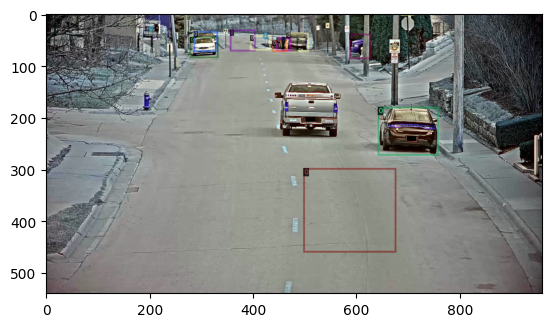

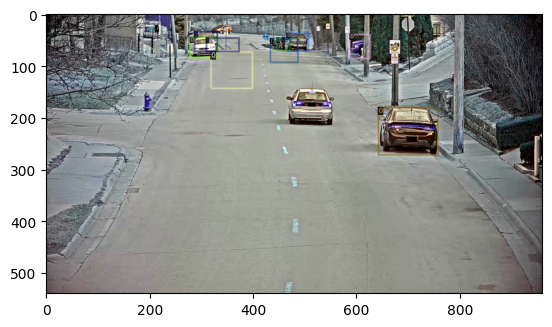

In [12]:
import random

# Visualize some random samples
for d in random.sample(DatasetCatalog.get("train_dataset"), 2):
    img = cv2.imread(d["file_name"])
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=detector._metadata["train"], scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [8]:
detector._metadata["train"]

namespace(name='datafolds/train_12', thing_classes=['car', 'bike'])

In [12]:
detector._datasets["train"]

In [14]:
train_loader = DatasetCatalog.get("train_dataset")
train_metadata = MetadataCatalog.get("train_dataset")


val_loader = DatasetCatalog.get("val_dataset")
val_metadata = MetadataCatalog.get("val_dataset")

[03/05 17:21:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

{'instances': Instances(num_instances=12, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 369.6110,  298.7347,  415.0943,  389.0478],
        [1125.6765,  131.6272, 1539.3468,  218.3566],
        [1310.5707,   27.3160, 1378.8217,  378.1991],
        [1167.6245,   59.7265, 1563.8746,  149.4978],
        [1316.0098,   91.1115, 1366.8287,  207.1972],
        [1233.0505,   40.2239, 1428.8655,  224.2437],
        [1285.5618,  107.3335, 1404.2322,  167.9274],
        [ 373.7715,   95.5872,  476.3556,  179.7043],
        [ 328.0338,  241.6643,  484.2046,  387.1056],
        [ 911.5593,  150.1218, 1662.6748,  412.0079],
        [ 314.1271,  252.9235,  447.6695,  304.7192],
        [1184.0057,   57.3547, 1353.6443,  210.1844]], device='cuda:0')), scores: tensor([0.5454, 0.5318, 0.5290, 0.5192, 0.5146, 0.5093, 0.5079, 0.5070, 0.5044,
        0.5043, 0.5037, 0.5033], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')])}


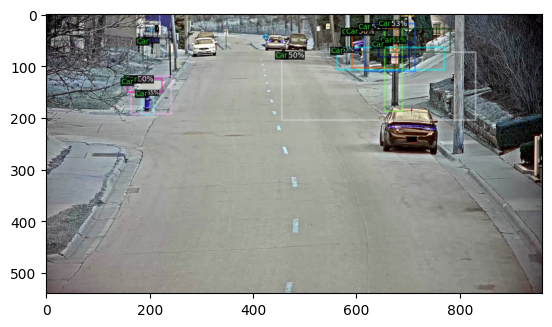

In [17]:
import random
from detectron2.utils.visualizer import ColorMode

predictor = DefaultPredictor(detector.cfg)
for d in random.sample(train_loader, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    instances = outputs["instances"]
    out = v.draw_instance_predictions(instances.to("cpu"))
    boxes = v._convert_boxes(outputs["instances"].pred_boxes.to('cpu')).squeeze()

    for box in boxes:
        out = v.draw_text(f"Car", (box[0], box[1]))
        
    plt.imshow(out.get_image()[:, :, ::-1])

In [20]:
detector.cfg.MODEL.WEIGHTS = os.path.join(detector.cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
detector.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(detector.cfg)

[03/05 14:10:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./kfolds_13/faster/model_final.pth ...


In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("train_12", output_dir="./output")
val_loader = build_detection_test_loader(detector.cfg, "train_12")

(inference_on_dataset(predictor.model, detector._datasets["train"], evaluator))

[03/05 14:18:14 d2.evaluation.coco_evaluation]: Trying to convert 'train_12' to COCO format ...
[03/05 14:18:14 d2.data.datasets.coco]: Converting annotations of dataset 'train_12' to COCO format ...)
[03/05 14:18:14 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/05 14:18:15 d2.data.datasets.coco]: Conversion finished, #images: 727, #annotations: 7628
[03/05 14:18:15 d2.data.datasets.coco]: Caching COCO format annotations at './output/train_12_coco_format.json' ...
[03/05 14:18:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/05 14:18:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/05 14:18:15 d2.data.common]: Serializing 727 elements to byte tensors and concatenating them all ...
[03/05 14:18:15 d2.data.common]: Serialized dataset takes 0.85 MiB
[03/05 14:18:15 d2.evaluation.evaluato

TypeError: string indices must be integers